In [3]:
import numpy as np
from sklearn.utils.extmath import svd_flip, randomized_svd
from scipy.sparse.linalg import svds
import torch
import matplotlib.pyplot as plt
import sys
import scipy.io as sio

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
if device == 'cuda':
    # when using GPU use this block of code
    gpu_path = '/home/akumar/data/KLCPD_data/code'
    sys.path.append(gpu_path)
    from main import KL_CPD
    protein_data_path = '/home/akumar/data/protein-data-code/dataset/1h9t_traj_xyz.pkl'
else:
    # when using CPU use this block of code
    cpu_path = '/Users/aniketkumar/Desktop/Aniket/ML/cpd-pytorch/MDTrAnal_exp/klcpd-code'
    sys.path.append(cpu_path)
    from main import KL_CPD
    protein_data_path = './dataset/1h9t_traj_xyz.pkl'

protein_data_path

'./dataset/1h9t_traj_xyz.pkl'

In [6]:
def svd_wrapper(Y, k, method='svds'):
    if method == 'svds':
        Ut, St, Vt = svds(Y, k)
        idx = np.argsort(St)[::-1]
        St = St[idx] # have issue with sorting zero singular values
        Ut, Vt = svd_flip(Ut[:, idx], Vt[idx])
    elif method == 'random':
        Ut, St, Vt = randomized_svd(Y, k, random_state=0)
    else:
        Ut, St, Vt = np.linalg.svd(Y, full_matrices=False)
        # now truncate it to k
        Ut = Ut[:, :k]
        St = np.diag(St[:k])
        Vt = Vt[:k, :]
        
    return Ut, St, Vt

In [7]:
def get_xyz_coordinates():
    xyz_coordinates = torch.load(protein_data_path)
    (x1, y1, z1) = xyz_coordinates.shape
    xyz_coordinates = xyz_coordinates.reshape(x1, y1*z1, order='C')
    print(f'Original dataset shape: {xyz_coordinates.shape}')
    return xyz_coordinates

In [8]:
def get_reduced_data(components, svd_method):
    p_data = get_xyz_coordinates()
    X, _, _ = svd_wrapper(p_data, components, method=svd_method)
    print(f'Reduced dataset shape: {X.shape}')
    return X

In [9]:
def train_and_pred_dataset(dataset):
    dimension = dataset.shape[1]
    model = KL_CPD(dimension).to(device)
    model.fit(dataset)
    return model.predict(dataset)

In [10]:
def plot_data(dataset, predictions, reduction_method, skip_components=0):
    components = dataset.shape[1]
    # get the min and max values for y-axis
    min_y=float('inf')
    max_y=float('-inf')
    for i in range(components):
        if skip_components == i+1:
            continue
        min_y = min(min_y, min(dataset[:,i]))
        max_y = max(max_y, max(dataset[:,i]))

    for i in range(components):
        if skip_components == i+1:
            continue
        plt.subplot(components+1,1,i+1)
        plt.plot(dataset[:,i])
        plt.title(f'Component {i+1}')
        plt.ylim([min_y-0.2, max_y+0.2])
        plt.subplot(components+1, 1, components+1)

    plt.plot(predictions)
    plt.title('MMD')
    plt.suptitle(f'{reduction_method} with {components-skip_components} component(s) visualization')
    plt.tight_layout()
    plt.show()

Working with 1h9t Dataset

In [11]:
svd_method = 'random'
components = 3
protein_reduced = get_reduced_data(components, svd_method)

Original dataset shape: (6570, 26979)
Reduced dataset shape: (6570, 3)


In [12]:
protein_predictions = train_and_pred_dataset(protein_reduced)

100%|██████████| 100/100 [56:25<00:00, 33.86s/it]


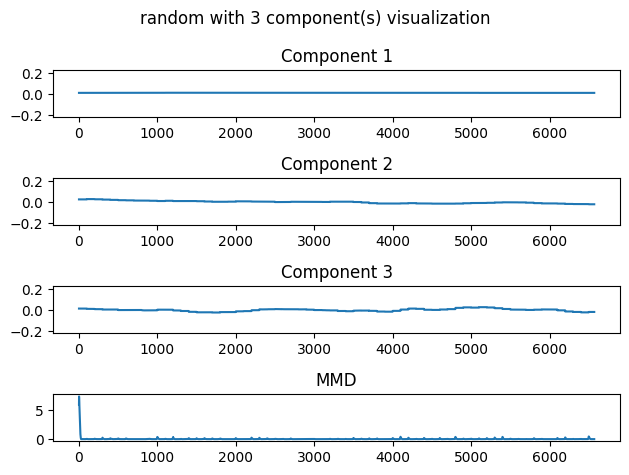

In [13]:
plot_data(protein_reduced, protein_predictions, svd_method)

Training model with last two components

In [14]:
protein_predictions = train_and_pred_dataset(protein_reduced[:, 1:])

100%|██████████| 100/100 [59:21<00:00, 35.62s/it]


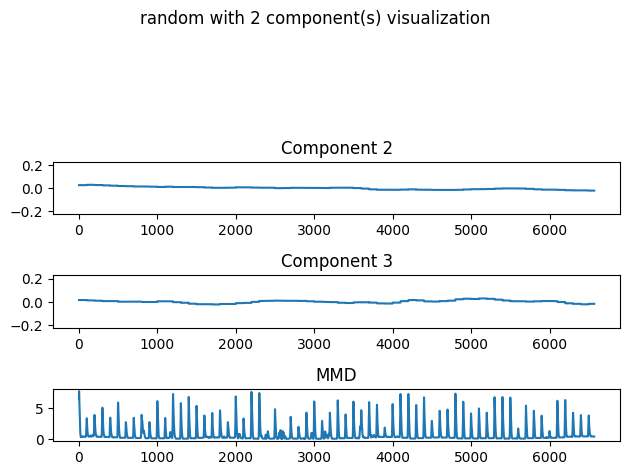

In [15]:
plot_data(protein_reduced, protein_predictions, svd_method, skip_components=1)

In [16]:
svd_method = 'svds'
components = 3
protein_reduced = get_reduced_data(components, svd_method)

Original dataset shape: (6570, 26979)
Reduced dataset shape: (6570, 3)


In [17]:
protein_predictions = train_and_pred_dataset(protein_reduced)

100%|██████████| 100/100 [5:45:14<00:00, 207.14s/it] 


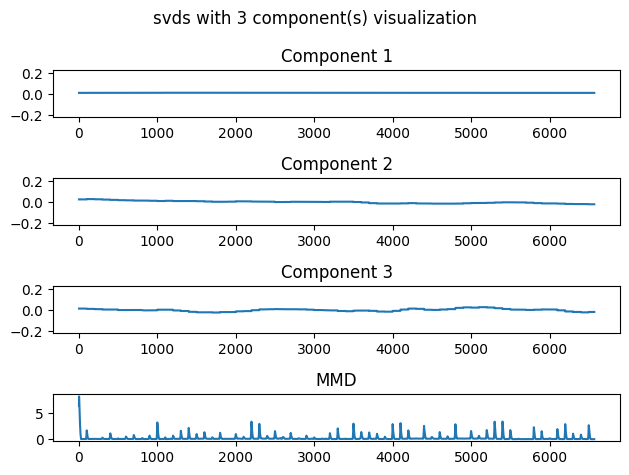

In [18]:
plot_data(protein_reduced, protein_predictions, svd_method)

In [19]:
svd_method = 'random'
components = 6
protein_reduced = get_reduced_data(components, svd_method)

Original dataset shape: (6570, 26979)
Reduced dataset shape: (6570, 6)


In [20]:
protein_predictions = train_and_pred_dataset(protein_reduced)

100%|██████████| 100/100 [59:23<00:00, 35.63s/it]


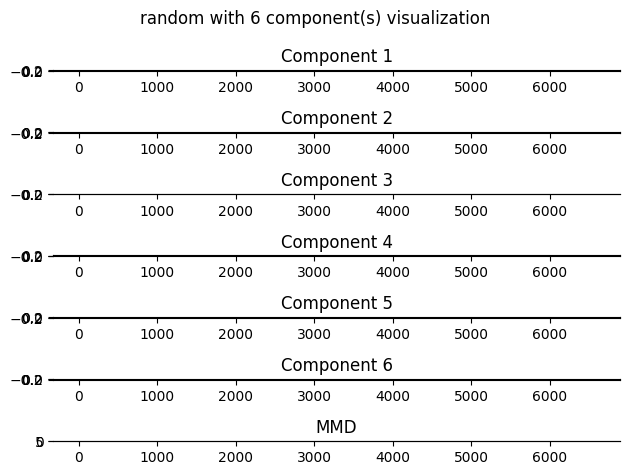

In [25]:
plot_data(protein_reduced, protein_predictions, svd_method)

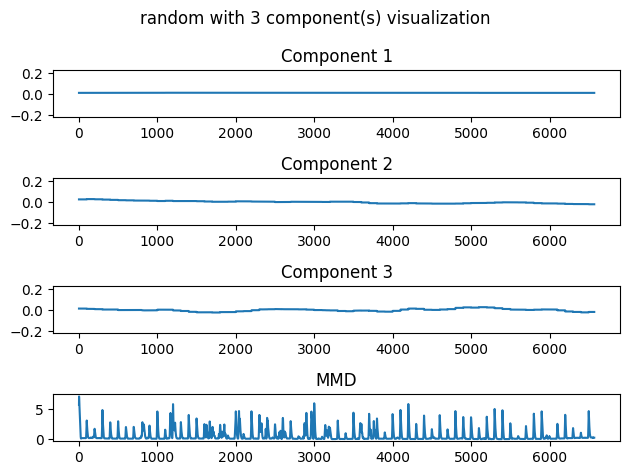

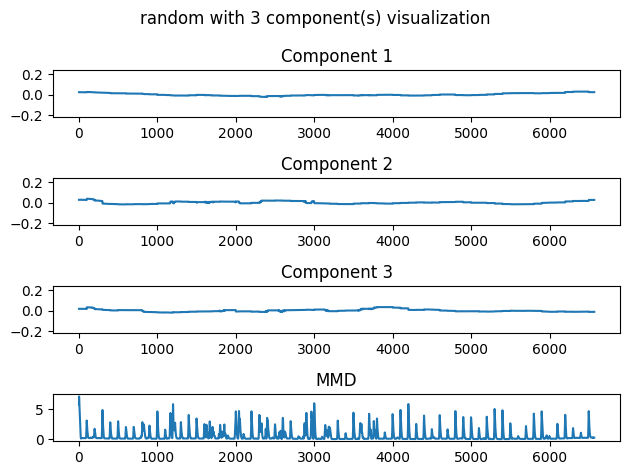

In [28]:
plot_data(protein_reduced[:,:3], protein_predictions, svd_method)
plot_data(protein_reduced[:,3:], protein_predictions, svd_method)